In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Mecab
from wordcloud import WordCloud
from gensim.models.word2vec import Word2Vec
font_path = '/home/devcat/anaconda3/envs/devcat/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf'

%matplotlib inline
mecab = Mecab()

In [2]:
stop_words = pd.read_csv('./stopwords.txt',encoding='utf-8')
doc1 = pd.read_csv('/home/devcat/data/AA/smart_store.txt',sep='\t')
doc2 = pd.read_csv('/home/devcat/data/AA/news.txt',sep='\t')

In [3]:
def regex(data):
    x = [re.sub(r'\[[^)]*\]','',kw).rstrip(' ').lstrip(' ').lstrip(']').lstrip('[') for kw in [data]]
    x = ''.join(x)
    text = re.sub('[0123456789.a.b.c.d.e.f.g.h.i.j.k.l.m.n.o.p.q.r.s.t.u.v.w.x.y.z;\-\_=+#/\?:^$.,@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', x.lower())
    return text

def process(data):
    clean_doc = []
    for sen in data:
        if 'http' in sen:
            continue
        elif '---' in sen:
            continue
        else: clean_doc.append(sen)
    return clean_doc

def corr(key1, key2, image=False):
    corr_count = {keyword : int(key1[keyword]+key2[keyword]/2) for keyword in key1.keys() if keyword in key2.keys()}
    if image==True:
        wordcloud = WordCloud(
        font_path = font_path,
        width=800,
        height=800,
        background_color='white'
        )
        wordcloud = wordcloud.generate_from_frequencies(corr_count)
        img_array = np.array(wordcloud.to_image())
        fig = plt.figure(figsize=(10, 10))
        plt.imshow(img_array, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return corr_count

def keyword_run(doc, image=False):
    doc = doc['Message'].tolist()
    stop = stop_words['words'].tolist()
    doc = [regex(sen) for sen in doc]
    doc = process(doc)
    keyword = [mecab.nouns(sen) for sen in doc]
    keyword = list(itertools.chain.from_iterable(keyword))
    keyword = [word for word in keyword if word not in stop]
    count = Counter(keyword)
    key_count = {n:c for n, c in count.most_common(150) if len(n)>=2}
    if image == True:
        wordcloud = WordCloud(
        font_path = font_path,
        width=800,
        height=800,
        background_color='white'
        )
        wordcloud = wordcloud.generate_from_frequencies(key_count)
        img_array = np.array(wordcloud.to_image())
        fig = plt.figure(figsize=(10, 10))
        plt.imshow(img_array, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    
    return key_count 

def embedding_run(doc):
    doc = doc['Message'].tolist()
    stop = stop_words['words'].tolist()
    clean_doc = process(doc)
    clean_doc = [regex(sen) for sen in clean_doc]
    keyword = [mecab.nouns(sen) for sen in clean_doc]
    keyword = [word for word in keyword if word not in stop]
    results = []
    for idx, sen in enumerate(keyword):
        results.append([])
        for word in sen:
            if len(word)>=2:results[idx].append(word)
    results = [sen for sen in results if len(sen)!=0]
    
    return results

In [4]:
doc1_results = embedding_run(doc1)
doc1_keyword = keyword_run(doc1)
doc2_results = embedding_run(doc2)
doc2_keyword = keyword_run(doc2)
corr_keyword = corr(doc1_keyword,doc2_keyword)
data = doc1_results+doc2_results

In [5]:
%%time
model = Word2Vec(data)

CPU times: user 432 ms, sys: 3.97 ms, total: 436 ms
Wall time: 327 ms


In [6]:
key_list=list(itertools.chain.from_iterable(doc1_results))

In [10]:
corr_list = list(corr_keyword.keys())

In [23]:
embedding_list = []
embedding_dict = {}
for idx,keyword in enumerate(corr_list):
    embedding_list.append([])
    for key_vector in model.wv.most_similar(keyword):
        embedding_list[idx].append(key_vector[0])
    embedding_dict[keyword]=embedding_list[idx]

In [43]:
embedding_dict[corr_list[0]]

['기업', '가능', '중국', '시장', '업체', '검색', '한국', '경제', '관련', '생각']

In [44]:
embedding_dict[corr_list[0]][0]

'기업'

In [35]:
final_dict={}
for corr_key in corr_list:
    for keyword in embedding_dict[corr_key]:
        temp = 0
        if keyword in doc1_keyword: temp+=doc1_keyword[keyword]
        elif keyword in doc2_keyword: temp+=doc2_keyword[keyword]
        temp = int(temp/2)
        final_dict[keyword]=temp

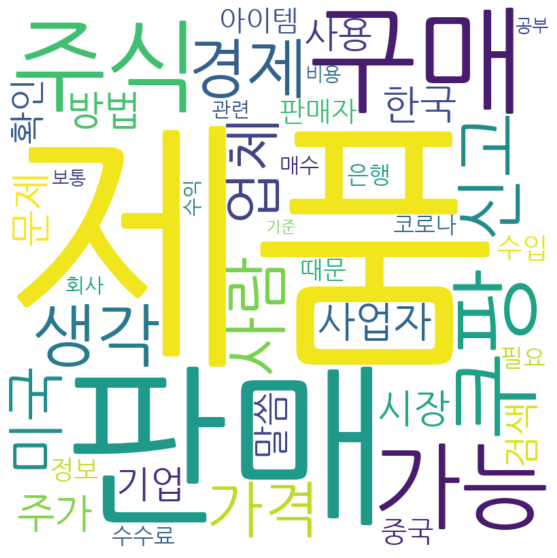

In [41]:
wordcloud = WordCloud(
        font_path = font_path,
        width=800,
        height=800,
        background_color='white'
        )
wordcloud = wordcloud.generate_from_frequencies(final_dict)
img_array = np.array(wordcloud.to_image())
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_array, interpolation="bilinear")
plt.axis("off")
plt.show()

문제점<br>
1. counter에 등록되지 않은 단어에 대해 스코어 매기는게 불가능(이걸 늘려야하나..?)
2. 임베딩자체가 잘 되지 않음 << 이건 lovit님 블로그에 관련 글 있어서 읽어봐야할듯